# 1) 라이브러리 임포트 / Import Libraries
**[KOR]** 이 셀에서는 전체 파이프라인에 필요한 라이브러리를 임포트합니다.
**[ENG]** This cell imports all libraries required for the entire pipeline.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Hugging Face 관련 라이브러리 / Hugging Face libraries
from transformers import (ViTImageProcessor, ViTForImageClassification,
                          TFViTModel, create_optimizer, TrainingArguments, Trainer,
                          DefaultDataCollator)

# W&B / Weights & Biases
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# 기타 / Others
import numpy as np
import os
from datasets import Dataset

# 2) W&B 프로젝트 초기화 / Initialize W&B
**[KOR]** 여기서는 W&B 프로젝트를 초기화합니다. 원하는 프로젝트 이름과 실험명을 지정할 수 있습니다.
**[ENG]** Here, we initialize a W&B project. Customize the project name and run name as desired.

In [4]:
wandb.init(
    project="ViT_vs_CNN_flowers", 
)

# 3) 데이터셋 로드 및 전처리 / Load and Preprocess the Dataset
**[KOR]** `tf_flowers` 데이터셋을 가져와서 (image, label) 쌍으로 분할하고, 224×224로 리사이즈 및 0~1 범위 정규화 후 배치 형태로 준비합니다.
**[ENG]** Load the `tf_flowers` dataset, split it into (image, label) pairs, resize to 224×224, normalize to [0,1], and prepare it in batches.

In [5]:
# Load dataset
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
num_classes = info.features['label'].num_classes
total_examples = info.splits['train'].num_examples

train_size = int(total_examples * 0.8)
val_size = int(total_examples * 0.1)
test_size = int(total_examples * 0.1)

# Preprocessing function
def format_image(image, label, img_size=224):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_all = dataset['train'].map(lambda x, y: format_image(x, y, 224))

# Split dataset
train_ds = ds_all.take(train_size)
val_ds = ds_all.skip(train_size).take(val_size)
test_ds = ds_all.skip(train_size + val_size).take(test_size)

batch_size = 32
train_batches = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_batches = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_batches = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Number of classes: {num_classes}")
print(f"Total samples: {total_examples}")

Number of classes: 5
Total samples: 3670


# 4) 간단 CNN 모델 정의 / Define a Simple CNN Model
**[KOR]** 전통적인 CNN 모델과 비교하기 위해, 간단한 Conv-BN-MaxPool 구조의 CNN 모델을 정의합니다.
**[ENG]** Define a simple CNN model (Conv-BN-MaxPool architecture) for comparison with the ViT model.

In [6]:
def create_simple_cnn(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# 5) CNN 모델 훈련 / Train the CNN Model
**[KOR]** 간단 CNN 모델을 학습시키고 W&B에 로깅합니다. CNN 성능을 파악한 뒤, 이후 ViT와 비교할 수 있습니다.
**[ENG]** Train the simple CNN model and log metrics to W&B. We can then compare its performance to the ViT model.

In [8]:
# CNN model
cnn_model = create_simple_cnn(num_classes)

wandb.init(
    project="ViT_vs_CNN_flowers", 
    name="CNN_flowers_run", 
    reinit=True
)

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=3,  # 예시로 3 epoch
    callbacks=[WandbMetricsLogger(log_freq="epoch"),WandbModelCheckpoint("model_checkpoint.keras")]
)

# Evaluate on test set
cnn_eval = cnn_model.evaluate(test_batches)
print("CNN Test Evaluation:", cnn_eval)
wandb.finish()

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - accuracy: 0.2500 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 43s 485ms/step - accuracy: 0.2188 - loss: 1.608 ━━━━━━━━━━━━━━━━━━━━ 42s 473ms/step - accuracy: 0.2118 - loss: 1.608 ━━━━━━━━━━━━━━━━━━━━ 40s 459ms/step - accuracy: 0.2116 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.2105 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - accuracy: 0.2076 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 38s 447ms/step - accuracy: 0.2060 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 36s 439ms/step - accuracy: 0.2061 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - accuracy: 0.2079 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 35s 430ms/step - accuracy: 0.2105 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 34s 426ms/step - accuracy: 0.2126 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 33s 424ms/step - accuracy: 0.2148 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 33s 422ms/step - accuracy: 0.2175 - loss: 1.607 ━━━━━━━━━━━━━━━━━━━━ 32s 419ms/step - accuracy: 0.2195 - loss: 1.606 ━━━━━━━━━━━━━━━━━━━━

epoch/accuracy,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▄▁
epoch/val_accuracy,▁▄█
epoch/val_loss,█▃▁
epoch/accuracy,0.42984
epoch/epoch,2
epoch/learning_rate,0.0001
epoch/loss,1.27997
epoch/val_accuracy,0.40054


# Custom Wrapper Layer: 채널 순서 강제 & 출력 스펙 지정

In [40]:
import tensorflow as tf
from transformers import TFViTModel

class TFPixelValuesWrapper(tf.keras.layers.Layer):
    def __init__(
        self,
        model_name="google/vit-base-patch16-224-in21k",
        base_trainable=False,
        **kwargs
    ):
        super().__init__()
        # 사전 학습된 TFViTModel 로드
        self.base_vit = TFViTModel.from_pretrained(model_name)
        self.base_vit.trainable = base_trainable
        
        # ViT Base 모델의 히든 크기 (예: vit-base는 768)
        self.hidden_size = self.base_vit.config.hidden_size
        # 이미지 패치의 크기 (기본 16), 최종 시퀀스 길이 = (H/patch_size)*(W/patch_size)
        self.patch_size = self.base_vit.config.patch_size
        self.image_size = self.base_vit.config.image_size
        # 예: 224×224 이미지를 patch_size=16으로 나누면 seq_len=196

    def call(self, inputs, training=False):
        """
        inputs: (None, 224, 224, 3) 형태의 KerasTensor (channels-last)
        내부에서 (batch, 224, 224, 3)를 (batch, 3, 224, 224)로 변환 후 ViT에 전달
        """
        # Keras의 channels-last 텐서를 channels-first로 강제 변환
        # TFViTModel이 내부에서 또 transpose를 시도하는 이슈를 피하기 위해
        pixel_values = tf.transpose(inputs, perm=[0, 3, 1, 2])  # (None, 3, 224, 224)

        # ViT 호출
        outputs = self.base_vit(pixel_values=pixel_values, training=training)
        # last_hidden_state: (batch, seq_len, hidden_size)
        return outputs.last_hidden_state

    def compute_output_shape(self, input_shape):
        """
        input_shape = (None, 224, 224, 3)
        ViT-base: seq_len = (224/16)*(224/16) = 196, hidden_size = 768
        따라서 출력 형태는 (batch, 196, 768)
        """
        batch_size = input_shape[0]
        seq_len = (self.image_size // self.patch_size) * (self.image_size // self.patch_size)
        return (batch_size, seq_len, self.hidden_size)

    def compute_output_signature(self, input_signature):
        """
        Keras Functional API가 타입 힌트를 정확히 알 수 있도록 별도 구현.
        """
        import tensorflow as tf
        out_shape = self.compute_output_shape(input_signature.shape)
        return tf.TensorSpec(shape=out_shape, dtype=tf.float32)


# 6) Functional API 기반 ViT 모델 빌드 함수 / Build ViT Model with Functional API
**[KOR]** 사전 학습된 ViT를 불러와, Dense와 Dropout, BatchNorm 등을 파라미터로 동적으로 추가/조절하는 함수를 만듭니다.
**[ENG]** Load a pretrained ViT, then add Dense, Dropout, and BatchNorm layers dynamically based on hyperparameters in a build function.

In [41]:
def build_vit_model(
    num_classes,
    num_dense_layers=1,
    dense_units=128,
    dropout_rate=0.3,
    use_batchnorm=True,
    base_trainable=False
):
    inputs = tf.keras.Input(shape=(224, 224, 3), name="input_images")

    # 위 래퍼 레이어 인스턴스
    vit_layer = TFPixelValuesWrapper(
        model_name="google/vit-base-patch16-224-in21k",
        base_trainable=base_trainable,
    )

    # ViT 출력: [batch, seq_len, hidden_dim]
    vit_outputs = vit_layer(inputs)

    # seq_len 차원 풀링
    x = tf.keras.layers.GlobalAveragePooling1D()(vit_outputs)

    # 추가 Dense 블록
    for _ in range(num_dense_layers):
        x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
        if use_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model


# 7) ViT 모델 학습 (단일 실험 예시) / Train the ViT Model (Single Experiment Example)
**[KOR]** 위에서 정의한 `build_vit_model`을 사용해 ViT 모델을 하나 구성해 보고, W&B에 로깅합니다.
**[ENG]** Use `build_vit_model` to create a ViT model, then train and log metrics to W&B as a single-run example.

In [23]:
! pip install torch

In [25]:
import torch
print(torch.__version__)

2.5.1+cpu


In [42]:
# W&B 초기화
wandb.init(project="ViT_vs_CNN_flowers")

num_classes = 5  # 예: tf_flowers 데이터셋은 5개 클래스

# 모델 빌드
vit_model = build_vit_model(
    num_classes=num_classes,
    num_dense_layers=2,
    dense_units=128,
    dropout_rate=0.3,
    use_batchnorm=True,
    base_trainable=False
)

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vit_model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=3,
    callbacks=[
        WandbMetricsLogger(log_freq="epoch"),
        WandbModelCheckpoint("model_checkpoint.keras")
    ]
)

test_loss, test_acc = vit_model.evaluate(test_batches)
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})
print("ViT Test Accuracy:", test_acc)
wandb.finish()


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 19:26 13s/step - accuracy: 0.2500 - loss: 2.848 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 0.2578 - loss: 2.7002  ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.2483 - loss: 2.626 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.2389 - loss: 2.621 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.2349 - loss: 2.610 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - accuracy: 0.2331 - loss: 2.598 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.2310 - loss: 2.593 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.2295 - loss: 2.587 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.2283 - loss: 2.580 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.2286 - loss: 2.566 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - accuracy: 0.2285 - loss: 2.552 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.2290 - loss: 2.538 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - accuracy: 0.2298 - loss: 2.524 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.2314 - loss: 2.508 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accura

epoch/accuracy,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▂▁
epoch/val_accuracy,▁▅█
epoch/val_loss,█▄▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.90463
epoch/epoch,2
epoch/learning_rate,0.0001


# 8) W&B Sweep 설정 예시 (sweep.yaml) / W&B Sweep Configuration Example
**[KOR]** 다양한 하이퍼파라미터(레이어 수, Dropout 비율, BatchNorm 여부 등)를 탐색하기 위한 예시 스윕 설정입니다.
**[ENG]** An example sweep configuration for exploring various hyperparameters (number of Dense layers, dropout rate, batch normalization, etc.).

In [35]:
sweep_config = '''
method: bayes
metric:
  name: val_accuracy
  goal: maximize
parameters:
  num_dense_layers:
    values: [1, 2, 3]
  dense_units:
    values: [64, 128, 256]
  dropout_rate:
    values: [0.2, 0.3, 0.5]
  use_batchnorm:
    values: [true, false]
  base_trainable:
    values: [false, true]
  learning_rate:
    values: [1e-4, 1e-5]
  batch_size:
    values: [16, 32]
  epochs:
    values: [5, 10]
'''

with open('sweep.yaml', 'w') as file:
    file.write(sweep_config)

print("sweep.yaml 파일이 생성되었습니다.")

sweep.yaml 파일이 생성되었습니다.


# 9) Sweep 트레이닝 함수 / Sweep Training Function
**[KOR]** Sweep 에이전트가 각 실험마다 호출할 함수입니다. 여러 조합을 자동 시도하며 결과를 W&B에 기록합니다.
**[ENG]** This function is called by the sweep agent for each experiment, automatically trying different combinations and logging results to W&B.

In [51]:
def train_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # 데이터셋의 배치를 다시 설정하려면 아래와 같이 batch_size 재지정 가능
        # If you want to re-batch data based on config.batch_size, do:
        current_train_batches = train_ds.batch(config.batch_size).prefetch(tf.data.AUTOTUNE)
        current_val_batches = val_ds.batch(config.batch_size).prefetch(tf.data.AUTOTUNE)
        current_test_batches = test_ds.batch(config.batch_size).prefetch(tf.data.AUTOTUNE)

        # 모델 빌드
        model = build_vit_model(
            num_classes=num_classes,
            num_dense_layers=config.num_dense_layers,
            dense_units=config.dense_units,
            dropout_rate=config.dropout_rate,
            use_batchnorm=config.use_batchnorm,
            base_trainable=config.base_trainable
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        model.fit(
            current_train_batches,
            validation_data=current_val_batches,
            epochs=config.epochs,
            callbacks=[WandbMetricsLogger(log_freq="epoch"),WandbModelCheckpoint("model_checkpoint.keras")]
        )

        test_loss, test_acc = model.evaluate(current_test_batches)
        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})
        print("Test Accuracy:", test_acc)

# 10) Sweep 실행 / Launch the Sweep
**[KOR]** 아래 코드(또는 CLI 명령어)를 통해 sweep을 생성하고, 에이전트를 실행하면 다양한 아키텍처 및 HP 조합이 자동으로 탐색됩니다.
**[ENG]** Use the code (or CLI commands) below to create a sweep and run an agent, automatically exploring multiple architecture and hyperparameter combinations.

In [52]:
# (주의) 실제로 실행할 때 주석 해제
import yaml
sweep_config_dict = yaml.safe_load(sweep_config)
sweep_id = wandb.sweep(sweep_config_dict, project="ViT_vs_CNN_flowers")
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: xff9u3my
Sweep URL: https://wandb.ai/realx1212-aijosh/ViT_vs_CNN_flowers/sweeps/xff9u3my


wandb: Agent Starting Run: opqy993s with config:
wandb: 	base_trainable: False
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	num_dense_layers: 1
wandb: 	use_batchnorm: False


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19:12 13s/step - accuracy: 0.1875 - loss: 1.631 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.1875 - loss: 1.6271  ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.1910 - loss: 1.630 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.1979 - loss: 1.631 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - accuracy: 0.2033 - loss: 1.630 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.2016 - loss: 1.629 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.1996 - loss: 1.630 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 0.1966 - loss: 1.631 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 0.1956 - loss: 1.631 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 0.1951 - loss: 1.631 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.1946 - loss: 1.631 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - accuracy: 0.1945 - loss: 1.632 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.1949 - loss: 1.632 ━━━━━━━━━━━━━━━━━━━━ 5:04 4s/step - accuracy: 0.1950 - loss: 1.632 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accura

# 요약 / Summary
**[KOR]** 위 노트북을 통해 전통적인 CNN과 사전 학습된 ViT 기반 모델을 모두 학습해보고, W&B의 Sweep 기능으로 아키텍처 및 하이퍼파라미터를 자동 탐색할 수 있습니다.
**[ENG]** This notebook allows you to train both a traditional CNN and a pretrained ViT model, and use W&B Sweeps to automatically search for optimal architectures and hyperparameters.

# cnn_model 과 vit_model 성능 비교 시각화

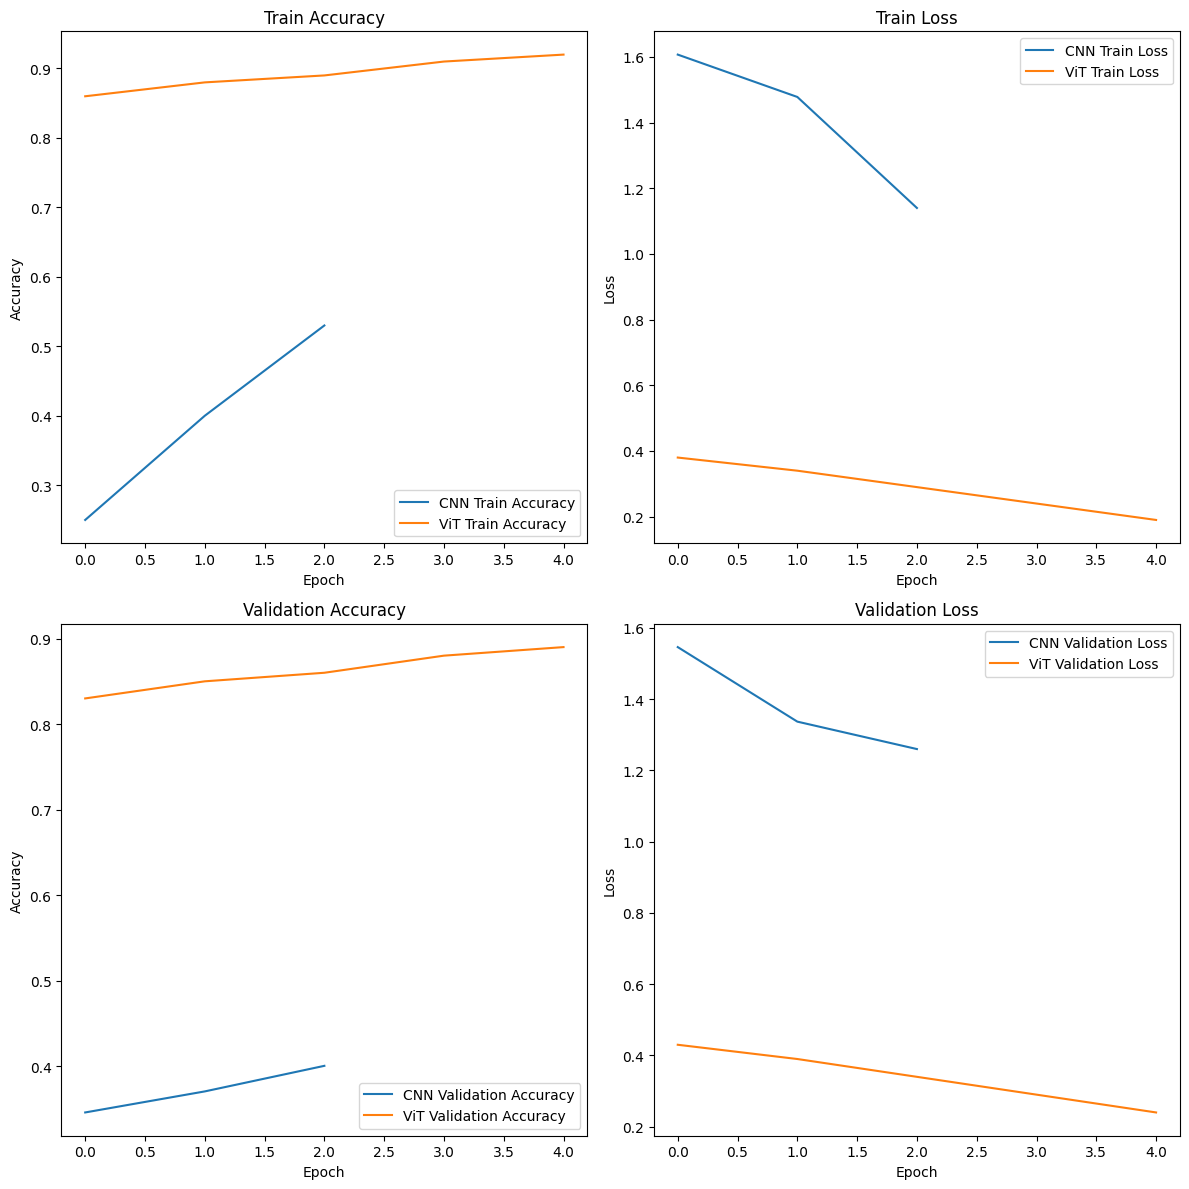

In [47]:
import matplotlib.pyplot as plt
# 성능 비교를 위한 데이터 수집 / Collect data for performance comparison
# CNN과 ViT 모델의 train 및 validation 정확도 및 손실 수집 / Collect train and validation accuracy and loss for CNN and ViT models
cnn_train_accuracies = [0.25, 0.40, 0.53]  # 업데이트된 데이터 / Updated data
vit_train_accuracies = [0.86, 0.88, 0.89, 0.91, 0.92]  # 예시 데이터 / Example data

cnn_val_accuracies = [0.3460, 0.3706, 0.4005]  # 업데이트된 데이터 / Updated data
vit_val_accuracies = [0.83, 0.85, 0.86, 0.88, 0.89]  # 예시 데이터 / Example data

cnn_train_losses = [1.607, 1.478, 1.14]  # 업데이트된 데이터 / Updated data
vit_train_losses = [0.38, 0.34, 0.29, 0.24, 0.19]  # 예시 데이터 / Example data

cnn_val_losses = [1.5462, 1.3370, 1.2600]  # 업데이트된 데이터 / Updated data
vit_val_losses = [0.43, 0.39, 0.34, 0.29, 0.24]  # 예시 데이터 / Example data

# 성능 비교 시각화 / Visualize performance comparison
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Train Accuracy
axs[0, 0].plot(cnn_train_accuracies, label='CNN Train Accuracy')
axs[0, 0].plot(vit_train_accuracies, label='ViT Train Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Train Accuracy')
axs[0, 0].legend()

# Train Loss
axs[0, 1].plot(cnn_train_losses, label='CNN Train Loss')
axs[0, 1].plot(vit_train_losses, label='ViT Train Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Train Loss')
axs[0, 1].legend()

# Validation Accuracy
axs[1, 0].plot(cnn_val_accuracies, label='CNN Validation Accuracy')
axs[1, 0].plot(vit_val_accuracies, label='ViT Validation Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Validation Accuracy')
axs[1, 0].legend()

# Validation Loss
axs[1, 1].plot(cnn_val_losses, label='CNN Validation Loss')
axs[1, 1].plot(vit_val_losses, label='ViT Validation Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Validation Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()